In [ ]:
!pip install ta
!pip install scikeras

# Github com os arquivos
!git clone https://github.com/LuFaiotto/tech-challenge.git

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f2c08d3b0ea560d05744918d65a7d83d836c0227c690081ffdb249d945e1e480
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
Cloning into 'tech-challenge'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 166 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 59.56 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# Modelo LightGBM - Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns # Para matriz de confusão

# Lendo arquivo do Github para criação de dataframe
df_obesity = pd.read_csv('/content/tech-challenge/Fase_4/Obesity_normalizado.csv', sep=',', engine='python')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
df_obesity.head()

,Gender,N_Gender,Age,N_Age,Height,N_Height,Weight,N_Weight,family_history,N_family_history,...,FAF,N_FAF,TUE,N_TUE,CALC,N_CALC,MTRANS,N_MTRANS,Obesity,N_Obesity
0,Female,"1,00","21,00","0,15","1,62","0,32","64,00","0,19",yes,"1,00",...,"0,00","0,00","1,00","0,50",no,"0,00",Public_Transportation,"0,50",Normal_Weight,"0,17"
1,Female,"1,00","21,00","0,15","1,52","0,13","56,00","0,13",yes,"1,00",...,"3,00","1,00","0,00","0,00",Sometimes,"0,33",Public_Transportation,"0,50",Normal_Weight,"0,17"
2,Male,"0,00","23,00","0,19","1,80","0,66","77,00","0,28",yes,"1,00",...,"2,00","0,67","1,00","0,50",Frequently,"0,67",Public_Transportation,"0,50",Normal_Weight,"0,17"
3,Male,"0,00","27,00","0,28","1,80","0,66","87,00","0,36",no,"0,00",...,"2,00","0,67","0,00","0,00",Frequently,"0,67",Walking,"0,00",Overweight_Level_I,"0,33"
4,Male,"0,00","22,00","0,17","1,78","0,62","89,80","0,38",no,"0,00",...,"0,00","0,00","0,00","0,00",Sometimes,"0,33",Public_Transportation,"0,50",Overweight_Level_II,"0,50"



Mapeamento das Classes de Obesidade para 'Obesity':
  Insufficient_Weight: 0
  Normal_Weight: 1
  Obesity_Type_I: 2
  Obesity_Type_II: 3
  Obesity_Type_III: 4
  Overweight_Level_I: 5
  Overweight_Level_II: 6
Iniciando busca por hiperparâmetros com GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 17
[LightGBM] [Info] Start training from score -2.046805
[LightGBM] [Info] Start training from score -1.997578
[LightGBM] [Info] Start training from score -1.792945
[LightGBM] [Info] Start training from score -1.963240
[LightGBM] [Info] Start training from score -1.874472
[LightGBM] [Info] Start training from score -1.98456

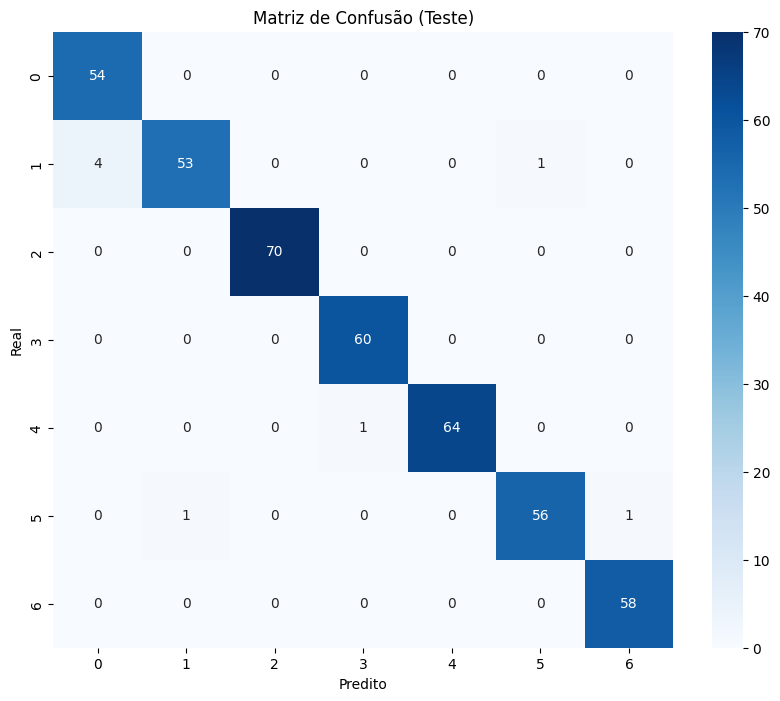


Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       0.98      0.91      0.95        58
           2       1.00      1.00      1.00        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.98      0.97      0.97        58
           6       0.98      1.00      0.99        58

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423



In [ ]:
# Target
target_column = 'Obesity'

# Cálculo do IMC
# Conversão para float
df_obesity['Height'] = df_obesity['Height'].astype(str).str.replace(',', '.').astype(float)
df_obesity['Weight'] = df_obesity['Weight'].astype(str).str.replace(',', '.').astype(float)

df_obesity['IMC'] = df_obesity['Weight'] / (df_obesity['Height']**2)

# Normalização do IMC
scaler_imc = MinMaxScaler()
df_obesity['N_IMC'] = scaler_imc.fit_transform(df_obesity[['IMC']])

# Features
features = [col for col in df_obesity.columns if col.startswith('N_') and col != 'N_Obesity']

# Codificando o target (Obesity)
label_encoder = LabelEncoder()
df_obesity[target_column] = label_encoder.fit_transform(df_obesity[target_column])

print(f"\nMapeamento das Classes de Obesidade para '{target_column}':")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")

for col in features:
    if df_obesity[col].dtype == 'object': # Convertendo os dados Object
        df_obesity[col] = df_obesity[col].astype(str).str.replace(',', '.').astype(float)

X = df_obesity[features]
y = df_obesity[target_column]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização das features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criação do DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

# Modelo LightGBM
def criar_modelo_lgbm(n_estimators=100, learning_rate=0.001, max_depth=5, num_leaves=31):
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(label_encoder.classes_), # Número de classes únicas no LabelEncoder
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        random_state=42,
        n_jobs=-1
    )
    return model

# Validação Cruzada com StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Hiperparâmetros
parametros = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'num_leaves': [20, 31, 50]
}

# GridSearchCV
print("Iniciando busca por hiperparâmetros com GridSearchCV...")
grid_search = GridSearchCV(
    estimator=criar_modelo_lgbm(),
    param_grid=parametros,
    cv=skf,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

melhor_modelo = grid_search.best_estimator_
melhor_hiperparametro = grid_search.best_params_
melhor_resultado = grid_search.best_score_

print("\nMelhor acurácia: %f com %s" % (melhor_resultado, melhor_hiperparametro))

######### AVALIAÇÃO DO MODELO #########

y_pred_train = melhor_modelo.predict(X_train)

print('\n================================================')
print('================== MODELO LGBM =================')
print('================================================')
print('========== MÉTRICAS - BASE DE TREINO ===========')
print('Acurácia:', accuracy_score(y_train, y_pred_train))
print('Precisão (weighted):', precision_score(y_train, y_pred_train, average='weighted'))
print('Recall (weighted):', recall_score(y_train, y_pred_train, average='weighted'))
print('F1 Score (weighted):', f1_score(y_train, y_pred_train, average='weighted'))


######### MÉTRICAS NA BASE DE TESTE #########
y_pred_test = melhor_modelo.predict(X_test)

print('\n=========== MÉTRICAS - BASE DE TESTE ===========')
print('Acurácia:', accuracy_score(y_test, y_pred_test))
print('Precisão (weighted):', precision_score(y_test, y_pred_test, average='weighted'))
print('Recall (weighted):', recall_score(y_test, y_pred_test, average='weighted'))
print('F1 Score (weighted):', f1_score(y_test, y_pred_test, average='weighted'))

# Matriz de Confusão
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão (Teste)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Relatório de Classificação (Teste)
print('\nRelatório de Classificação (Teste):')
print(classification_report(y_test, y_pred_test))
